<a href="https://colab.research.google.com/github/kridtapon/Vortex-BreakGuard/blob/main/Vortex_BreakGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# --- Vortex Indicator ---
def calculate_vortex(df, period=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)

    vm_plus = (high - low.shift()).abs()
    vm_minus = (low - high.shift()).abs()

    vi_plus = vm_plus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    vi_minus = vm_minus.rolling(window=period).sum() / tr.rolling(window=period).sum()

    return vi_plus, vi_minus

# --- Chande Kroll Stop ---
def calculate_cks(df, period=10, atr_multiplier=1.5):
    atr = df['High'].combine(df['Low'], max) - df['Low'].combine(df['High'], min)
    atr = atr.rolling(window=period).mean()

    highest_close = df['Close'].rolling(window=period).max()
    lowest_close = df['Close'].rolling(window=period).min()

    cks_long = lowest_close - atr_multiplier * atr
    cks_short = highest_close + atr_multiplier * atr

    return cks_long, cks_short

# --- Download price data ---
symbol = 'COR'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Indicators ---
df['VI+'], df['VI-'] = calculate_vortex(df)
df['CKS_Long'], df['CKS_Short'] = calculate_cks(df)

# --- Entry and Exit Conditions ---
df['Entry'] = (df['VI+'] > df['VI-']) & (df['CKS_Long'] > df['CKS_Long'].shift(10)) & (df['CKS_Short'] > df['CKS_Short'].shift(10))
df['Exit'] = (df['VI-'] > df['VI+']) & (df['CKS_Long'] < df['CKS_Long'].shift(10)) & (df['CKS_Short'] < df['CKS_Short'].shift(10))

# --- Filter date range for test period ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift signals to avoid lookahead bias ---
entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# --- Backtest Portfolio ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Results ---
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  168709.927305
Total Return [%]                               68.709927
Benchmark Return [%]                          180.407533
Max Gross Exposure [%]                             100.0
Total Fees Paid                              4315.872119
Max Drawdown [%]                               30.393416
Max Drawdown Duration                  683 days 00:00:00
Total Trades                                          20
Total Closed Trades                                   20
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                        35.0
Best Trade [%]                                 29.883322
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed



📈 Best Parameters:
Vortex          20.000
CKS             21.000
ATR Mult         1.200
Total Return     9.767
Name: 4468, dtype: float64


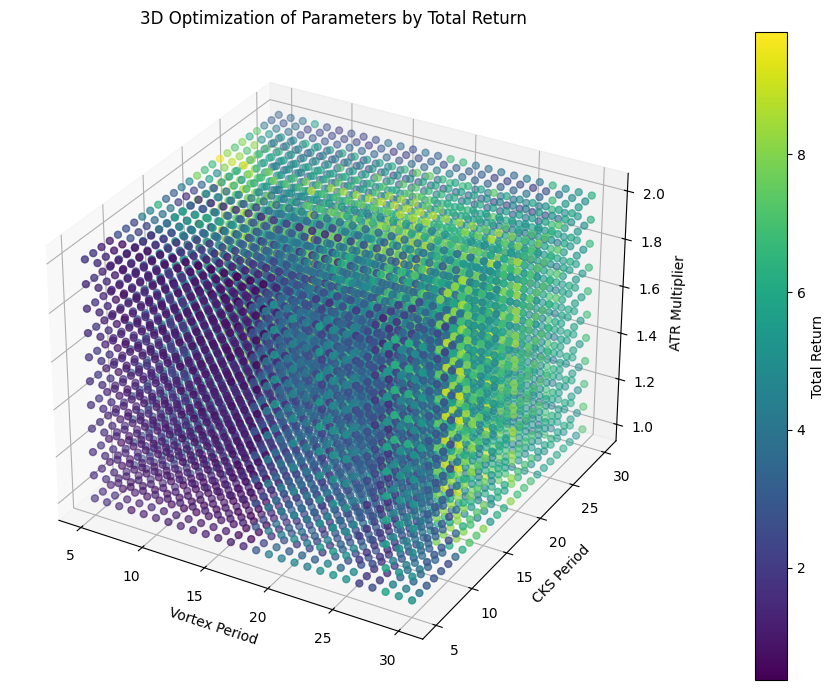

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import plotly.graph_objects as go

# --- Vortex Indicator ---
def calculate_vortex(df, period):
    high, low, close = df['High'], df['Low'], df['Close']
    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)

    vm_plus = (high - low.shift()).abs()
    vm_minus = (low - high.shift()).abs()

    vi_plus = vm_plus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    vi_minus = vm_minus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    return vi_plus, vi_minus

# --- Chande Kroll Stop ---
def calculate_cks(df, period, atr_multiplier):
    tr = df['High'].combine(df['Low'], max) - df['Low'].combine(df['High'], min)
    atr = tr.rolling(window=period).mean()
    highest_close = df['Close'].rolling(window=period).max()
    lowest_close = df['Close'].rolling(window=period).min()
    cks_long = lowest_close - atr_multiplier * atr
    cks_short = highest_close + atr_multiplier * atr
    return cks_long, cks_short

# --- Download price data ---
symbol = 'TPL'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Parameter Grid ---
vortex_periods = range(5, 31)
cks_periods = range(5, 31)
atr_multipliers = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
param_grid = list(product(vortex_periods, cks_periods, atr_multipliers))

# --- Storage ---
results = []
total_returns = {}

for vortex_p, cks_p, atr_m in param_grid:
    vi_plus, vi_minus = calculate_vortex(df, vortex_p)
    cks_long, cks_short = calculate_cks(df, cks_p, atr_m)

    entry = (vi_plus > vi_minus) & (cks_long > cks_long.shift(10)) & (cks_short > cks_short.shift(10))
    exit = (vi_minus > vi_plus) & (cks_long < cks_long.shift(10)) & (cks_short < cks_short.shift(10))

    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
    entry_test = entry[(entry.index.year >= 2020) & (df.index.year <= 2025)]
    exit_test = exit[(exit.index.year >= 2020) & (df.index.year <= 2025)]

    entries = entry_test.shift(1).astype(bool).fillna(False).to_numpy()
    exits = exit_test.shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(
        close=df_test['Open'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    ret = pf.total_return()
    total_returns[(vortex_p, cks_p, atr_m)] = ret
    results.append((vortex_p, cks_p, atr_m, ret))

# --- Find Best
results_df = pd.DataFrame(results, columns=['Vortex', 'CKS', 'ATR Mult', 'Total Return'])
best_row = results_df.loc[results_df['Total Return'].idxmax()]
print("\n📈 Best Parameters:")
print(best_row)

# --- 3D Plot using matplotlib ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert results to DataFrame if not already
results_df = pd.DataFrame(results, columns=['Vortex', 'CKS', 'ATR Mult', 'Total Return'])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = results_df['Vortex']
y = results_df['CKS']
z = results_df['ATR Mult']
c = results_df['Total Return']

sc = ax.scatter(x, y, z, c=c, cmap='viridis', s=25)

ax.set_xlabel('Vortex Period')
ax.set_ylabel('CKS Period')
ax.set_zlabel('ATR Multiplier')
ax.set_title('3D Optimization of Parameters by Total Return')

# Add color bar
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Total Return')

plt.tight_layout()
plt.show()



In [7]:
# --- Indicators ---
df['VI+'], df['VI-'] = calculate_vortex(df, period=20)
df['CKS_Long'], df['CKS_Short'] = calculate_cks(df , period=21, atr_multiplier=1.2)

# --- Entry and Exit Conditions ---
df['Entry'] = (df['VI+'] > df['VI-']) & (df['CKS_Long'] > df['CKS_Long'].shift(10)) & (df['CKS_Short'] > df['CKS_Short'].shift(10))
df['Exit'] = (df['VI-'] > df['VI+']) & (df['CKS_Long'] < df['CKS_Long'].shift(10)) & (df['CKS_Short'] < df['CKS_Short'].shift(10))

# --- Filter date range for test period ---
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# --- Shift signals to avoid lookahead bias ---
entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# --- Backtest Portfolio ---
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# --- Results ---
print(portfolio.stats())
portfolio.plot().show()

Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                   1096223.7029
Total Return [%]                              996.223703
Benchmark Return [%]                          367.270525
Max Gross Exposure [%]                             100.0
Total Fees Paid                              9038.919481
Max Drawdown [%]                               37.224466
Max Drawdown Duration                  272 days 00:00:00
Total Trades                                          12
Total Closed Trades                                   12
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   58.333333
Best Trade [%]                                 222.78884
Worst Trade [%]                

[*********************100%***********************]  1 of 1 completed


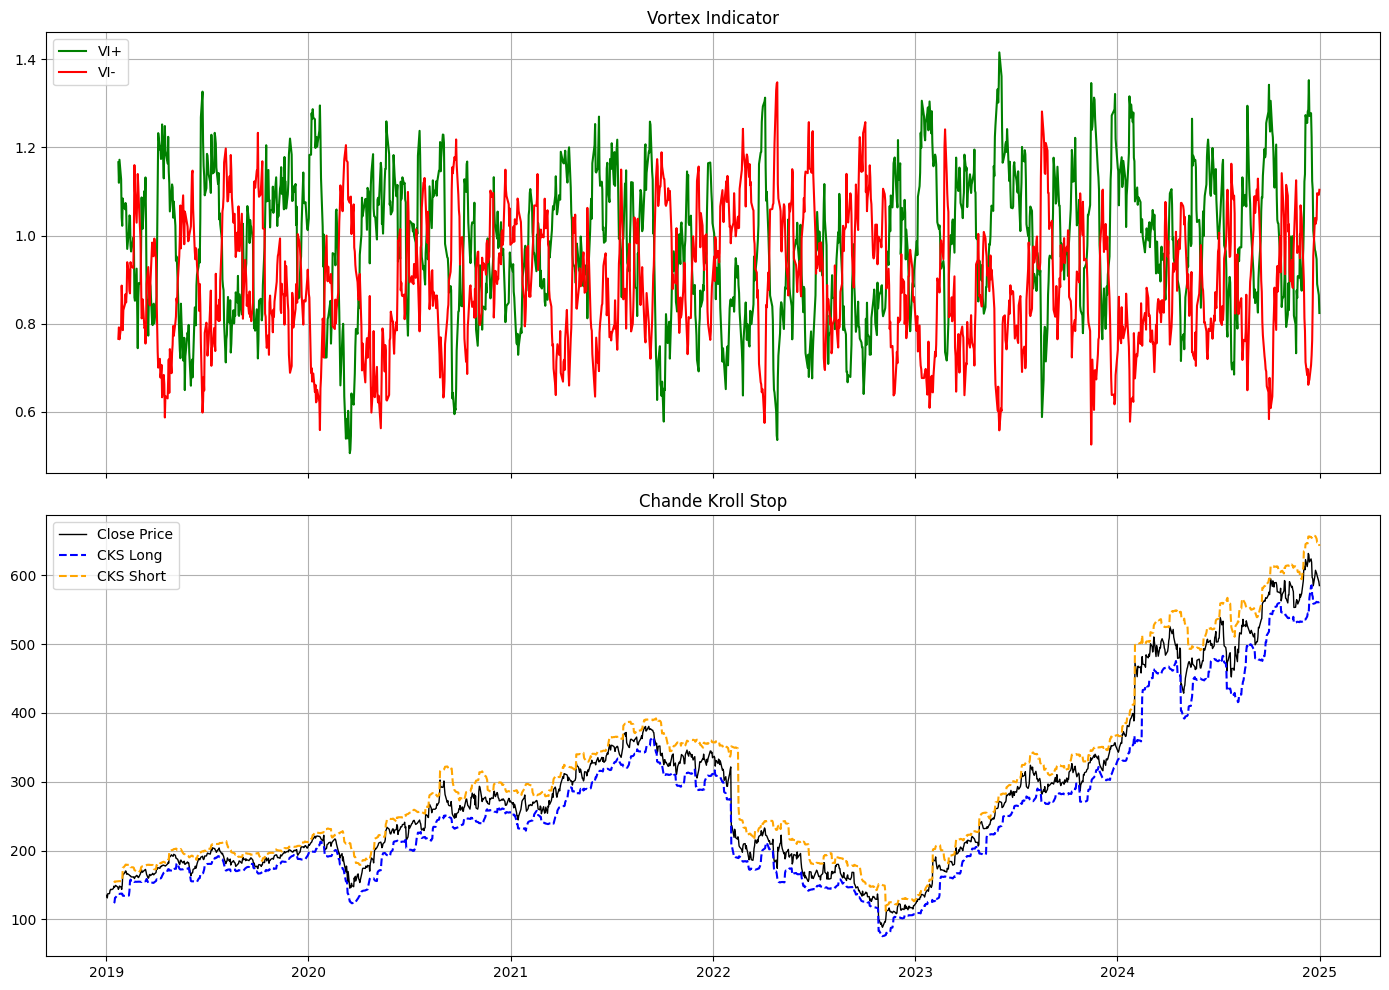

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# --- Vortex Indicator ---
def calculate_vortex(df, period=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1)

    vm_plus = (high - low.shift()).abs()
    vm_minus = (low - high.shift()).abs()

    vi_plus = vm_plus.rolling(window=period).sum() / tr.rolling(window=period).sum()
    vi_minus = vm_minus.rolling(window=period).sum() / tr.rolling(window=period).sum()

    return vi_plus, vi_minus

# --- Chande Kroll Stop ---
def calculate_cks(df, period=10, atr_multiplier=1.5):
    high = df['High']
    low = df['Low']
    close = df['Close']

    atr = pd.concat([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ], axis=1).max(axis=1).rolling(window=period).mean()

    highest_close = close.rolling(window=period).max()
    lowest_close = close.rolling(window=period).min()

    cks_long = lowest_close - atr_multiplier * atr
    cks_short = highest_close + atr_multiplier * atr

    return cks_long, cks_short

# --- Download price data ---
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# --- Calculate indicators ---
vi_plus, vi_minus = calculate_vortex(df)
cks_long, cks_short = calculate_cks(df)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Vortex Indicator
ax1.plot(df.index, vi_plus, label='VI+', color='green')
ax1.plot(df.index, vi_minus, label='VI-', color='red')
ax1.set_title('Vortex Indicator')
ax1.legend()
ax1.grid(True)

# Plot price and Chande Kroll Stop
ax2.plot(df['Close'], label='Close Price', color='black', linewidth=1)
ax2.plot(cks_long, label='CKS Long', color='blue', linestyle='--')
ax2.plot(cks_short, label='CKS Short', color='orange', linestyle='--')
ax2.set_title('Chande Kroll Stop')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
